# Thymio Project

# Kalman Filter
## Objective
For filtering we chose to take a Kalman filter. The principal task of the filter is to povide a good estimation about the position (x and y position in the global reference frame) and the pose (angle with respect to the x-axis) of the Thymio. 

## Integration
The entire filter is implemented inside the class _KalmanFilter_. Kalman filter assume a linear system. To reduce the linearization error it is good to update the filter at highest frequency possible. Therefore, we decided that the kalman filter should run in a different thread as the main loop that is updated more frequently. In the main an instance from the class _RepeatedTimer_ must be created. This object uses the _Timer_ class of python's _threading_ library and calls a given function at a period defined during initialisation. This way the function _KalmanFilter.update_filter_ can be calles periodically at 10Hz. The only auther public functions of the _KalmanFilter_ are _KalmanFilter.get_state_vector_, _KalmanFilter.get_covariance_matrix_ and _KalmanFilter.set_position_measurement_. Except of calling these functions the Kalman filter runs totally independent from the rest of the code. The two getter functions provide the estimated state vector [x position, y position, angle towards x axis, x velocity, y velocity, angular velocity] and the uncertainty estimation (covariance matrix of state vector).

## Measurements
One main advantage of the Kalman filter is its capability to merge multiple measurements coming from different sensors. In the case of our project, Thymio's speed sensors were taken as on board sensors and the camera as external measurement source. As explained before our goal was to use the external localisation ie. the camera as few as possible. Therefore, the Thymio should be able to run as long and as precise as possible just with the speed measurement. However, the speed sensors introduce a lot of noise into the system as for example the slippering of the wheels (that is not modeled). Hence, the "unprecision" of the filter must be estimated somehow. The great thing about the Kalman filter is that he is doing exactelly this by calculating the covariance matrix of the state vector. The assumptions is made that all noise is Gaussian. By an eigenvalue analysis we can calculate the standard deviation of the uncertainty in the worst direction ie. how good the estimation is supposed to be. As shown in equation 1, we take the second standard deviation because then we have a certainty of over 95% to be in the given distance from the estimated position:

\begin{equation*}
2\sigma_{max} = 2*\sqrt{max(|eigenvalues|)}
\label{eq:eigenvalues} \tag{1}
\end{equation*}

As soon the second standard deviation exceeds a certain freshold the main code will ask the camera to take another image and feed this to the kalman filter. This is done by the setter function _KalmanFilter.set_position_measurement_. The position measurment by the camera has a much lower uncertainty than the speed measurements and will correct the estimated position strongly using a large gain during the correction step. Also, the estimation uncertainty will be much lower after the picture was included into the filter. Allows the Thymio to move again for a certain time until its positional uncertainty gets too large and a new picture has to be taken. Out of simplicity, only the uncertainty of the position is considered (and not the one of the pose, velocity or rotation).


## Implementation
Our filter is a standard Kalman filter which does in each updating cycle first a prediction step using the system model and then a correction step using measurements (speed or spreed plus position). As theoretical the following resaurce was taken: ???. We want to point out to three particularities of our implementation.
1. When calculating the gain in the correction step the inverse of the so called measurement prediction covariance (S) is calculated. This covariance is composed by the updated estimation uncertainty (P) and the measurment uncertainty (R). If S is singular then it becomes impossible to calculate its inverse. If this is the case (det(s)=0) a small value is added to the diagonal of S. This addition is not influencing the resulting gain much but helps to overcome the singularity during calculation.

\begin{equation*}
S = H*P*H^{T} + R
\label{eq:predictionCov} \tag{2}
\end{equation*}


2. Also during the correction step the next estiation uncertainty (P) is calculated by an extended formula. The formula usual known in equation 3 is calculated by equation 4. This equation gives the same result. However, as described by Bucy, R. S. and Joseph, P. D. (_Filtering for Stochastic Processes with Applications to Guidance._ Interscience, 1968 New York”, Chapter 16) it is supposed to be more stable. During testing bove versions gave approximetally the same results. Because the speed of the algorithm has not to be optimized the more stable equation was chosen.

\begin{equation*}
P = (I -K*H)*P
\label{eq:estimationUncertainty} \tag{3}
\end{equation*}

\begin{equation*}
P = (I - K*H)*P*(I - K@H)^{T} + K*R*K^{T}
\label{eq:estimationUncertaintyRExt} \tag{4}
\end{equation*}

3. We encountered the problems that we measured always the same speed over a certain period of time using the following commands: _aw(self.node.wait_for_variables())_ and _left = self.node["motor.left.speed"]_. If executed the program gets just the speed measurement memorized in Thymio's cach. Unfortunatelly, thymio does not automatically update its cash when calling these functions. No, good solution was found for this problem also when discussing it with several assistances. However, if first a LED is set (_aw(self.node.set_variables({"leds.top":[0,0,10]}))_) and then the motor speed is measured Thymio's cash is updated and the measurement is not anymore corrupted.

## Tuning
In our implementation the estimated uncertainty is really important because first of all it is used to calculate the gain in the correction step. Second of all, it is taken as measurement when the position becomes too uncertain and a new image has to be taken. Therefore, the process noise and the measurement noise have to be well defined. We considered to make some experiments to determine the covariance matrices of the process noise (Q) and the measurement noise (R). However, a lot of data would have been needed to determine these matrices experimentally. Also, it would have been difficult to not introduce additional noise with those experiments. And, because no Thymio is like his other Thymio mate, all the experiments would have been needed to be done for each robot seperatly. Therefore, we decided to make an educated guess about the noise. Nevertheless, with some asumptions good estimations can be drawn.
* The Kalman filter is described in the global reference frame. However, the measurement of each motor speed is taken in the reference frame of the Thymio. Assuming that the left and the right motor are identically and the measurement noise can be described with a Gaussian function the speed measurement covariance matrix ($R_{speed}$) is derived from the cinematic model and given by equation 5. Hence, only one variable the measurement speed noise ($variance_{speed}$) has to be estimated.

\begin{equation*}
R_{speed} = \begin{bmatrix} \sigma_{vx} * \sigma_{vx} & \sigma_{vx} * \sigma_{vy} & \sigma_{vx} * \sigma_{v\alpha} \\
\sigma_{vx} * \sigma_{vy} & \sigma_{vy} * \sigma_{vy} & \sigma_{vy} * \sigma_{v\alpha} \\
\sigma_{vx} * \sigma_{v\alpha} & \sigma_{vy} * \sigma_{v\alpha} & \sigma_{v\alpha} * \sigma_{v\alpha} \end{bmatrix}
\label{eq:Rspeed} \tag{5}
\end{equation*}

>$\sigma_{vx} = \sqrt{|cos(\alpha)|*variance_{speed}}$, 
$\sigma_{vy} = \sqrt{|sin(\alpha)|*variance_{speed}}$, 
$\sigma_{v\alpha} = \sqrt{\frac{2*variance_{speed}}{width_{Thymio}}}$

* The process covariance matrix (Q) is determined similarly by assuming that the largest noise source during prediction is coming from the motors. Like for the measurement speed noise only one variable has to be estimated: the speed noise (variation in speed) during process ($variance_{process}). However, this time the noise on each variable is expected to be independent from each other. This is a simplification, but during testing it was observed that it performs better than the full covariance matrix.

\begin{equation*}
Q = \begin{bmatrix} \sigma_{x} * \sigma_{x} & 0 & 0 & 0 & 0 & 0 \\
0 & \sigma_{y} * \sigma_{y} & 0 & 0 & 0 & 0 \\
0 & 0 & \sigma_{\alpha} * \sigma_{\alpha} & 0 & 0 & 0 \\
0 & 0 & 0 & \sigma_{vx}*\sigma_{vx} & 0 & 0 \\
0 & 0 & 0 & 0 & \sigma_{vy}*\sigma_{vy} & 0 \\
0 & 0 & 0 & 0 & 0 & \sigma_{v\alpha}*\sigma_{v\alpha} \\ \end{bmatrix}
\label{eq:Q} \tag{6}
\end{equation*}

>$\sigma_{x} = \sqrt{\Delta t*|cos(\alpha)|*variance_{process}}$, 
$\sigma_{y} = \sqrt{\Delta t*|sin(\alpha)|*variance_{process}}$, 
$\sigma_{\alpha} = \sqrt{\Delta t*\frac{2*variance_{process}}{width_{Thymio}}}$
$\sigma_{vx} = \sqrt{|cos(\alpha)|*variance_{process}}$, 
$\sigma_{vy} = \sqrt{|sin(\alpha)|*variance_{process}}$, 
$\sigma_{v\alpha} = \sqrt{\frac{2*variance_{process}}{width_{Thymio}}}$

* For the position measurement noise an educated guess was made based on the experience accumulated when implementing the vision part ($R_{pos}$). Note that the variance of $R_{pos}$ is much smaller than the one from the previous covariance matrices.

\begin{equation*}
R_{pos} = \begin{bmatrix} variance_{pos} & 0 & 0 \\
0 & variance_{pos} & 0 \\
0 & 0 & variance_{\alpha} \end{bmatrix}
\label{eq:Rpos} \tag{7}
\end{equation*}

The numerical values of the constants are defined in the initialization part of the class _KalmanFilter_ and are the following. Note that these are variances given in $(\frac{cm}{s})^{2}$ or $(cm)^{2}$ respectivelly:

>$variance_{speed} = 2$ (measurement speed noise)

>$variance_{process} = 0.4$ (process speed noise)

>$variance_{pos} = 0.01$ (measurement position noise)

>$variance_{\alpha} = 0.003$ (measurement angle noise)



## Testing
During development the filter was tested in four steps:
1. Using "made up" speed measurements (list of given values) without doing any position measurements (Thymio node=0).
2. Using "made up" speed measurements and an interactive main. The interactive main was developed to simulate the position measurement of the camera. If the uncertainty becomes too hight it pauses the algorithm and asks the user through the terminal to enter the position of the Thymio. Then, it continues and merges the "position measurement" and the "speed measurement" during the next correction step.
3. Using real speed measurements of the Thymio and "made up" position measurements given by the interactive main explained in the previous step.
4. Using real speed measurements and real position measurements coming from the camera.

The code below shows the implementation of the Kalman filter and the main function used during testing stage 2. The speed measurements are given in the _speed_list_ defined in the initialization of _KalmanFilter_. The right motor runs first faster than the left one and initiates a curve by Thymio. Afterwards, the robot is going straight. The positional measurements have to be entered into the terminal if the algorithm pauses. The Kalman filter is at a frequency of 10Hz updated. The main makes 20 cycles in a for loop at approximetely 2.5Hz to illustrate the development of the system. The uncertainty threshold is set to 3cm.

In [1]:
import math
import time
import numpy as np
from tdmclient import ClientAsync, aw
from kalman_filter.repeated_timer import RepeatedTimer
from kalman_filter.plot_map import PlotMap

In [9]:
class KalmanFilter():
    def __init__(self, node, period, state_vector, position_uncertainty, print_variables=False):
        # node for connection with thymio
        self.node = node

        self.period = period # fiter updating period
        self.thymio_width = 9.4 # distance from wheel to wheel of thymio

        # state estimation vector: [position x, position y, angle, velocity x, velocity y, angular velocity]
        self.x = np.array(state_vector, dtype=float)

        # estimation uncertainty matrix (covariance matrix) of position and angle
        self.P = np.array(position_uncertainty, dtype=float)

        # positional measurement flag (if set then update kalman filter including positional measurement)
        self.m_pos_flag = False

        # positional measurement (measured by picture): [position x, position y, angel]
        self.m_pos = np.zeros((3), dtype=float)

        self.m_pos_noise = 0.01 # variance of positional measurement in x and y direction (estimated variance of camera)
        self.m_angular_noise = 0.003 # variance of angular pose measurement (estimated variance of camera)
        self.m_speed_noise = 2 # variance of speed measurement
        self.p_speed_noise = 0.4 # variance of speed during processing

        self.print_variables = print_variables # if true the state vector and the speed measurement are printed

        # if node=0 this list contains the "speed measurements" with which the kalman filter is tested
        self.speed_list = [[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],
                           [3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],
                           [3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3]]

    def set_position_measurement(self, position):
        self.m_pos = np.array(position, dtype=float)
        self.m_pos_flag = True

    def get_state_vector(self):
        return self.x

    def get_covariance_matrix(self):
        return self.P      

    def update_filter(self): 
        # measure speed and calc. velocity       
        speed = self._measure_speed()
        z = self._calc_velocity(speed)

        # calc. matrices used for kalman filter
        F, Q, H, R = self._calc_matrices()

        # make prediction step
        self.x, self.P = self._prediction(self.x, F, Q, self.P)

        # make correction step 
        self.x, self.P = self._correction(self.x, z, H, R, self.P)

        # reset flag because position measurement was used in last correction step
        if self.m_pos_flag:
            self.m_pos_flag = False

        # print variables for debugging if print_variable is set true
        if self.print_variables:
            print("x:\t{} {} {} {}".format(np.round(self.x[0:2], 2), np.round(np.rad2deg(self.x[2]),2), \
                                            np.round(self.x[4], 2), np.round(np.rad2deg(self.x[5]),2)))
            print("s:\t{}".format(np.round(speed, 2)))


    def _measure_speed(self):
        # if node is defined, the speed from thymio is measured
        if self.node != 0:
            # If the speed is measured directly like in the lines afterwards (wait for variables -> measure speed) 
            # the python code gets just the lastmvalue memorized in its cach. Nevertheless, thymio does not automatically 
            # update its cash. Therefore, first a LED is set (at a reallymlow value) and as consequence, the cash is updated.
            # This is not a good solution! However, it is working and because of time constraints is was not improved.
            aw(self.node.wait_for_variables())
            aw(self.node.set_variables({"leds.top":[0,0,10]}))
            left = self._convert_speed_to_cm(self.node["motor.left.speed"])
            right = self._convert_speed_to_cm(self.node["motor.right.speed"])          
            return [left, right]
        else:
            # if the kalman filter is tested without using the thymio the speed is taken from the speed_list (and not really measured)
            return self.speed_list.pop(0)

    def _convert_speed_to_cm(self, speed):
        # convert measured speed from thymio units back to cm/s
        return (16.0/500.0) * speed

    def _calc_velocity(self, speed):
        # calc. with speed (thymio reference frame) the velocity in x and y direction (absolute reference frame)
        m_vel = np.zeros((3), dtype=float)
        m_vel[0] = math.cos(self.x[2])*(speed[0]+speed[1])/2
        m_vel[1] = math.sin(self.x[2])*(speed[0]+speed[1])/2
        m_vel[2] = (speed[1]-speed[0])/self.thymio_width

        # return measurement variable z, if position was measured by the main (m_pos_flag was set) then the velocity 
        # and the positional measurements are merged
        if self.m_pos_flag:
            return np.concatenate((self.m_pos, m_vel), axis=0)
        else:
            return m_vel
        
    def _prediction(self, x, F, Q, P):   
        # calc. state estimation and estimation uncertainty after pretiction step
        x = F@x
        P = F@(P@np.transpose(F)) + Q       
        return x, P
    
    def _correction(self, x, z, H, R, P):
        # measurement prediction covariance
        S = H@(P@np.transpose(H)) + R

        # in case the inverse of S is singular add a small value to its diagonal
        # this step is done that the calculations are stable and has a neglictable influenc on the the result
        if np.linalg.det(S) == 0: 
            S = S + 0.01*np.identity(np.size(R, axis=0))

        # calc. kalman gain
        K = P@(np.transpose(H)@np.linalg.inv(S))              

        # calc inovation
        inovation = z - H@x

        # calc. state estimation and estimation uncertainty after correction step
        x = x + K@inovation

        # calc. estimation uncertainty after correction step, same as P = (I -K@H)@P but less unstable 
        #(see “Bucy, R. S. and Joseph, P. D. (1968). Filtering for Stochastic Processes with Applications to Guidance. 
        # Interscience, New York”, Chapter 16, “Roundoff errors” section.)
        I = np.identity(np.size(x))
        P = (I - K@H)@(P@np.transpose(I - K@H)) + K@(R@np.transpose(K))
        return x, P

    def _calc_matrices(self):
        # state transition matrix
        F = np.array([[1,0,0,self.period,0,0], 
                      [0,1,0,0,self.period,0], 
                      [0,0,1,0,0,self.period], 
                      [0,0,0,1,0,0],
                      [0,0,0,0,1,0],
                      [0,0,0,0,0,1]], dtype=float)

        # process uncertainty matrix
        p_std = np.zeros((6), dtype=float)
        p_std[0] = math.sqrt(self.period*abs(math.cos(self.x[2]))*self.p_speed_noise)
        p_std[1] = math.sqrt(self.period*abs(math.sin(self.x[2]))*self.p_speed_noise)
        p_std[2] = math.sqrt(self.period*2*self.p_speed_noise/self.thymio_width)
        p_std[3] = math.sqrt(abs(math.cos(self.x[2]))*self.p_speed_noise)
        p_std[4] = math.sqrt(abs(math.sin(self.x[2]))*self.p_speed_noise)
        p_std[5] = math.sqrt(2*self.p_speed_noise/self.thymio_width)
        Q = np.array([[p_std[0]*p_std[0],0,0,0,0,0], 
                      [0,p_std[1]*p_std[1],0,0,0,0], 
                      [0,0,p_std[2]*p_std[2],0,0,0],
                      [0,0,0,p_std[3]*p_std[3],0,0],
                      [0,0,0,0,p_std[4]*p_std[4],0],
                      [0,0,0,0,0,p_std[5]*p_std[5]]], dtype=float)

        # observation matrix
        H_pos = np.array([[1,0,0,0,0,0],
                          [0,1,0,0,0,0],
                          [0,0,1,0,0,0]], dtype=float)

        H_speed = np.array([[0,0,0,1,0,0],
                            [0,0,0,0,1,0],
                            [0,0,0,0,0,1]], dtype=float)

        # measurement uncertainty matrix
        m_std = np.zeros((3), dtype=float)
        m_std[0] = math.sqrt(abs(math.cos(self.x[2]))*self.m_speed_noise)
        m_std[1] = math.sqrt(abs(math.sin(self.x[2]))*self.m_speed_noise)
        m_std[2] = math.sqrt(2*self.m_speed_noise/self.thymio_width)
        R_speed = np.array([[m_std[0]*m_std[0],m_std[0]*m_std[1],m_std[0]*m_std[2]],
                            [m_std[0]*m_std[1],m_std[1]*m_std[1],m_std[1]*m_std[2]],
                            [m_std[0]*m_std[2],m_std[1]*m_std[2],m_std[2]*m_std[2]]], dtype=float)
        R_pos = np.array([[self.m_pos_noise,0,0],
                          [0,self.m_pos_noise,0],
                          [0,0,self.m_angular_noise]], dtype=float)

        # merge position and speed matrices if position measurement was made
        if self.m_pos_flag: 
            dim = np.size(R_pos, axis=0)
            Z = np.zeros((dim,dim))
            H = np.concatenate((H_pos, H_speed), axis=0)
            R = np.concatenate((np.concatenate((R_pos, Z), axis=0), \
                                np.concatenate((Z, R_speed), axis=0)), axis=1)
            return F, Q, H, R
        else:
            return F, Q, H_speed, R_speed



iteration 8
current estimated position: 8.5 2.0 32.2
enter x position: 8.5
enter y_position: 2.0
enter angle [in °]: 32.2
iteration 16
current estimated position: 14.3 7.6 50.7
enter x position: 15.3
enter y_position: 8.6
enter angle [in °]: 50.7


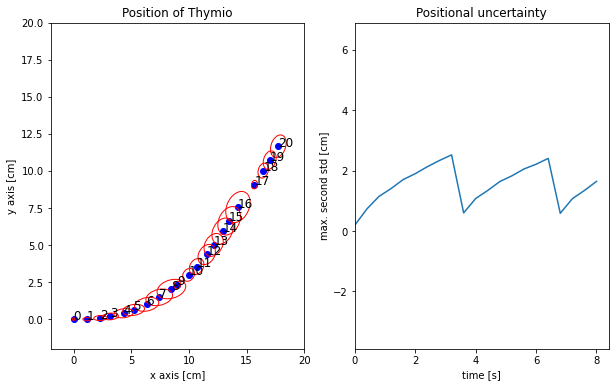

In [10]:
# define initiale speed and orientation
angle = np.deg2rad(0)
speed = 5

# calc. initiale velocity (speed in x and y direction)
vx = math.cos(angle)*speed
vy = math.sin(angle)*speed

# define initiale state vector: [position x, position y, angle, velocity x, velocity y, angular velocity]
state_vector = np.array([[0,0,angle,vx,vy,0]], dtype=float)

# define initiale covariance matrix, the estimated variance of the camera is taken
uncertainty_matrix = np.array([[[0.01,0,0,0,0,0],
                                [0,0.01,0,0,0,0],
                                [0,0,0.03,0,0,0],
                                [0,0,0,0,0,0],
                                [0,0,0,0,0,0],
                                [0,0,0,0,0,0]]], dtype=float)

# if no thymio is used set node equal to zero
# if node=0 speed is not measured but read from speed_list inside the kalman filter
node = 0

# define period at which the kalman filter is updated
period = 0.1

# create instance of the kalman filter
filter = KalmanFilter(node, period, state_vector[0], uncertainty_matrix[0])

# create instance of a repeated timer that calls the fct. update_filter at defined period
# the kalman filter runs in a separate thread prallel to the main
t1 = RepeatedTimer(period, filter.update_filter)

# start the kalman filter
t1.start()

# main loop
for i in range(20):
    # wait for a certain time until main requests next update from the kalman filter
    time.sleep(0.4)

    # get estimated position (state_vector) and uncertainty (covariance matrix) from kalman filter
    state_vector = np.append(state_vector, [filter.get_state_vector()], axis=0)
    uncertainty_matrix = np.append(uncertainty_matrix, [filter.get_covariance_matrix()], axis=0)

    # calc. second std: probability is more than 95% that robot is inside second std
    eigenvalues, _ = np.linalg.eig(uncertainty_matrix[i+1])
    stds2 = 2*np.sqrt(np.absolute(eigenvalues))

    # if uncertainty (second std) becomes larger than certain threshold the user is ask to enter the true position
    # in the end this step is automated by the camera, but for testing it is done by eye
    if np.amax(stds2) > 2.5:
        # stop kalman filter
        t1.stop()

        # ask user for true position/pose
        print("iteration {}".format(i+1))
        print("current estimated position: {} {} {}".format(np.round(state_vector[i+1][0],1), \
                                                            np.round(state_vector[i+1][1],1), \
                                                            np.round(np.rad2deg(state_vector[i+1][2]),1)))
        x_pos = float(input("enter x position: "))
        y_pos = float(input("enter y_position: "))
        angle = np.deg2rad(float(input("enter angle [in °]: ")))

        # send entered values to kalman filter which will include them in the next correction step
        filter.set_position_measurement([x_pos, y_pos, angle])

        #start again kalman filter
        t1.start()

# stopp kalman filter
t1.stop()

# plot results
PlotMap(period=0.4, position_list=state_vector, cov_list=uncertainty_matrix)

As seen in the right plot generated above the maximum uncertainty hits two times the threshold of 3cm: at iteration 8 and 16. Bove times the user is asked to enter a positional measurement (which is normally measured by the camera):
* At iteration 8, the estimated position is entered [8.5, 2.0, 32.2]. Therefore, Thymio's position is confirmed and the robot continues on its trajectory. Observe that the red ellipse on the right plot representing the second standard deviation shrinks a lot in the previous iteration (iteration 9). This can also be observed on the plot on right where the uncertainty drops after reaching 3cm. This is due to the fact that the position measurement of the camera is expected to have a small uncertainty.
* At iteration 16, the user is ask again to enter the position. This time one cm is added to the estimated x and y position [15.3, 8.6, 50.7] ie. Thymio run faster as the filter estimated it to do. Therefore, Thymio makes a jump forward in iteration 17.

Note that the uncertainty ellipses in red increase mostly in the direction of propagation of the robot. This is due to the fact that our model assumes that the estimation uncertainty comes mainly from Thymio's motors and these are moving Thymio longitudinal and not lateral.